# Credit Card Classification 

Source From : https://www.kaggle.com/competitions/playground-series-s3e4/overview
and  https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

Goal: Predict whether or not a given credit card transaction is fraudulent or legitimate (binary classification).

In [2]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

# visualisation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OrdinalEncoder

# model selection
from xgboost import XGBClassifier
import lightgbm as lgbm
from catboost import CatBoostClassifier
from lightgbm.sklearn import LGBMClassifier
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Data Preparation

Original Data combined with training data to augment our model's performance.
As a result, there are some duplicates to remove.


In [3]:
# read in data
X = pd.read_csv("./train.csv")
X_test = pd.read_csv("./test.csv")
original_data = pd.read_csv("./creditcard.csv")

# add source column
X['is_generated'] = 1
X_test['is_generated'] = 1
original_data['is_generated'] = 0

In [4]:
print(f"""X: {X.shape}
X_test: {X_test.shape}
original_data: {original_data.shape}
""")

X: (219129, 33)
X_test: (146087, 32)
original_data: (284807, 32)



In [5]:
# X_test is missing Class as expected, original_data is missing id
print([col for col in X.columns if col not in X_test.columns])
print([col for col in X.columns if col not in original_data.columns])

['Class']
['id']


In [6]:
# combine original_data and X into a single dataframe and reindex
X_combined = pd.concat([X, original_data], axis=0, ignore_index=True)

In [7]:


# remove duplicates
print(f"{len(X_combined) - len(X_combined.drop_duplicates())} duplicates to remove")
X_combined.drop_duplicates(inplace=True, ignore_index=True)



1081 duplicates to remove


In [8]:


# extract "id" column for later
test_ids = X_test['id']

# drop id from both sets as it provides no signal
cols_to_drop = ['id']
X_combined.drop(axis=1, columns=cols_to_drop, inplace=True)
X_test.drop(axis=1, columns=cols_to_drop, inplace=True)



## EDA


    No missing values
    Class is imbalanced
    Time should be bucketed into periods of a 24hr day
    A risk factor should be introduced for transactions with an amount less than $2.50


#### Missing Values

In [9]:
print(f"X_combined missing values: {X_combined.isna().sum().sum()}")
print(f"X_test missing values: {X_test.isna().sum().sum()}")

X_combined missing values: 0
X_test missing values: 0


There are no missing values to deal with

#### The target: Class

The target Class is overwhelmingly imbalanced towards legitimate transactions. We will use undersampling to train our models on more balanced data.

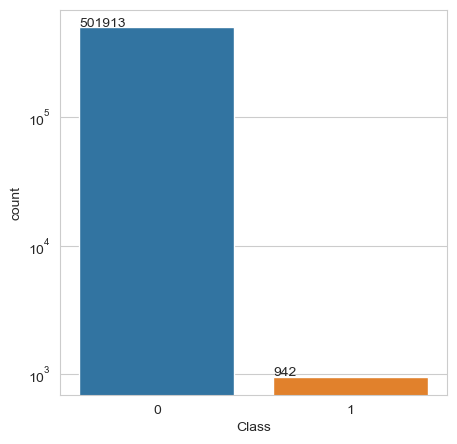

In [10]:
# use log scale to see both classes
fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x=X_combined['Class'])
ax.set_yscale('log')

for p in ax.patches:
    ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x(), p.get_height()+20))

#### Time

X and X_test span 2 distinct parts of a 48hr window in time. original_data spans the entire 48hr window by itself. Let's convert the time feature to hours for better readability.

In [11]:
X_temp = X_combined.loc[X_combined['is_generated'] == 1]
original_data_temp = X_combined.loc[X_combined['is_generated'] == 0]

In [12]:


original_data_temp



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,is_generated
219129,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0
219130,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0
219131,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0
219132,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0
219133,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
502850,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,-1.593105,2.711941,-0.689256,4.626942,-0.924459,1.107641,1.991691,0.510632,-0.682920,1.475829,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,0
502851,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,-0.150189,0.915802,1.214756,-0.675143,1.164931,-0.711757,-0.025693,-1.221179,-1.545556,0.059616,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,0
502852,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,0.411614,0.063119,-0.183699,-0.510602,1.329284,0.140716,0.313502,0.395652,-0.577252,0.001396,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,0
502853,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,-1.933849,-0.962886,-1.042082,0.449624,1.962563,-0.608577,0.509928,1.113981,2.897849,0.127434,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,0


In [13]:
print(f"X length in time: {((X_temp['Time'].max() - X_temp['Time'].min())/3600):.1f} hours")
print(f"X_test length in time: {((X_test['Time'].max() - X_test['Time'].min())/3600):.1f} hours")
print(f"Original Data length in time: {((X_combined['Time'].max() - X_combined['Time'].min())/3600):.1f} hours")


X length in time: 33.5 hours
X_test length in time: 14.5 hours
Original Data length in time: 48.0 hours


In [14]:


X_test['Time'] = X_test['Time']/3600
X_combined['Time'] = X_combined['Time']/3600

X_temp['Time'] = X_temp['Time']/3600
original_data_temp['Time'] = original_data_temp['Time']/3600





I am inclined to think t=0 corresponds to 12:00am. This is because the frequency of transactions is low in the early morning sleeping hours (0-8) and high during the day awake hours (9-24) i.e. transactions correlate with typical waking hours. Credit Card transactions (fradulent or not) cannot usually be made while asleep so this seems to be compelling.


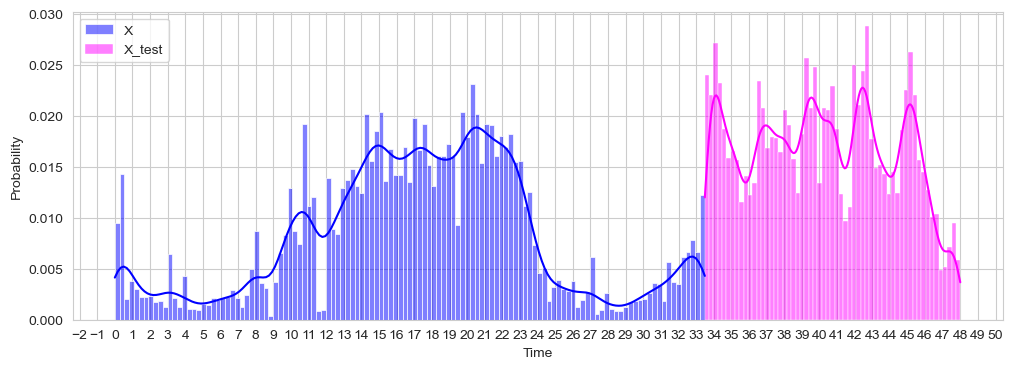

In [15]:
# distribution of X and X_test throughout the 48hr window
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=X_temp, x='Time', stat='probability',kde=True, color='b', label='X')
sns.histplot(data=X_test, x='Time', stat='probability', kde=True, color='magenta', label='X_test')
plt.legend()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

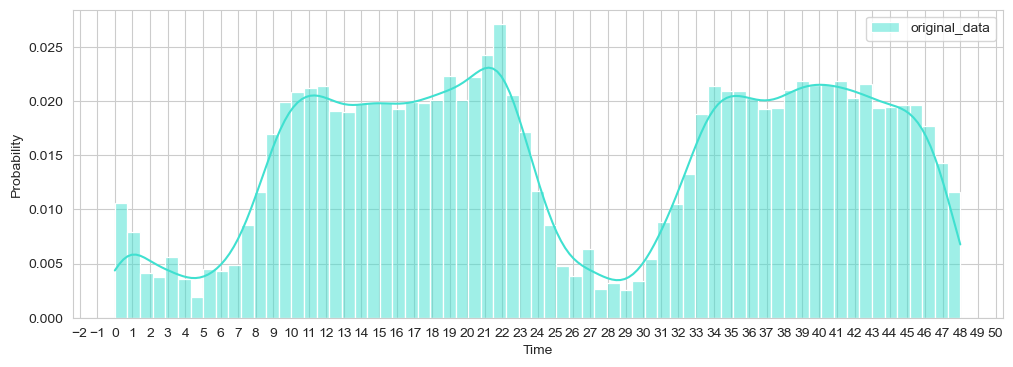

In [16]:
# distribution of original_data throughout the 48hr window
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=original_data_temp, x='Time', stat='probability',kde=True, color='turquoise', label='original_data')
plt.legend()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

Fraudulent transactions occur relatively more often in the late evening and at nightime than legitimate transactions, given their tiny percentage of the transactions. Time should, in some capacity, be used as a feature.

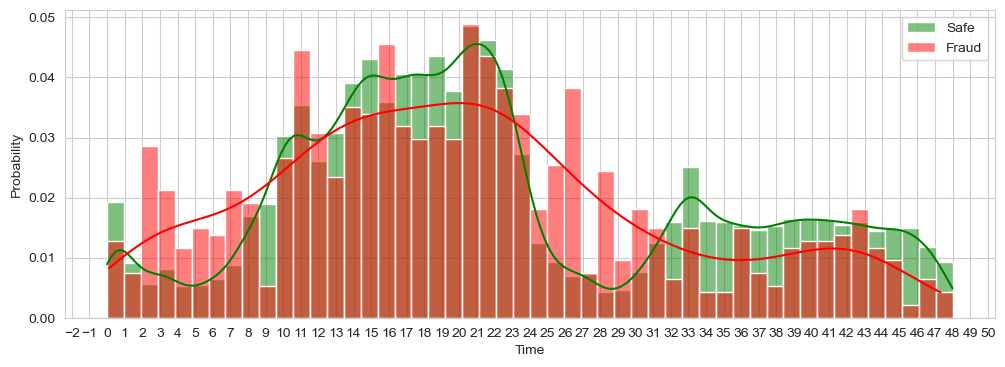

In [17]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=X_combined['Time'][X_combined['Class'] == 0],bins=50,binrange=(0,max(X_combined['Time'])), kde=True, stat='probability', color='g', label='Safe')
sns.histplot(data=X_combined['Time'][X_combined['Class'] == 1], bins=50, kde=True,binrange=(0,max(X_combined['Time'])), stat='probability', color='r', label='Fraud')
plt.legend()
ax.xaxis.set_major_locator(ticker.MultipleLocator(1));



A sensible new feature could be to bucket the time periods into:

(0-6): Early Morning, (6-12): Morning, (12-18): Afternoon, (18-24): Evening

We simply modulo 24 to fit all the data into these buckets.


In [18]:
X_combined['Time_bucket'] = pd.cut((X_combined.Time % 24),  bins=[0, 6, 12, 18, 24], include_lowest=True,
                               labels=["early_morning", "morning", "afternoon", "evening"])
X_test['Time_bucket'] = pd.cut((X_test.Time % 24),  bins=[0, 6, 12, 18, 24], include_lowest=True,
                               labels=["early_morning", "morning", "afternoon", "evening"])

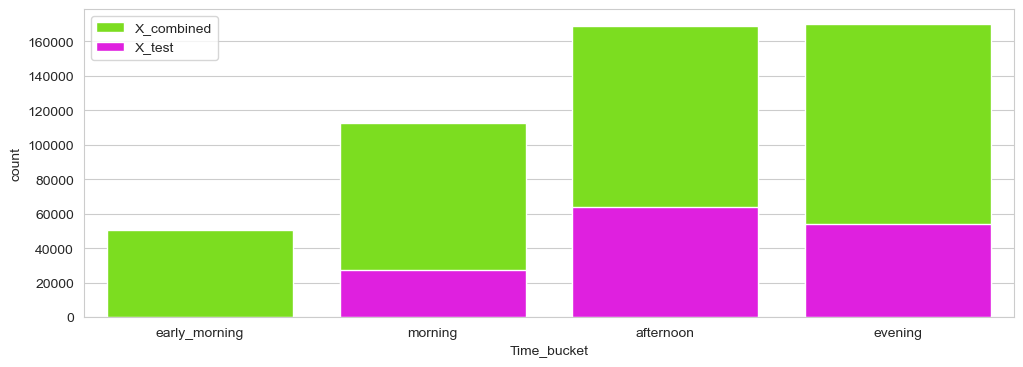

In [19]:
fig, ax = plt.subplots(figsize=(12,4))
sns.countplot(data=X_combined, x='Time_bucket', color='lawngreen', label='X_combined')
sns.countplot(data=X_test, x='Time_bucket', color='magenta', label='X_test')
plt.legend(loc='upper left')
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

#### Amount

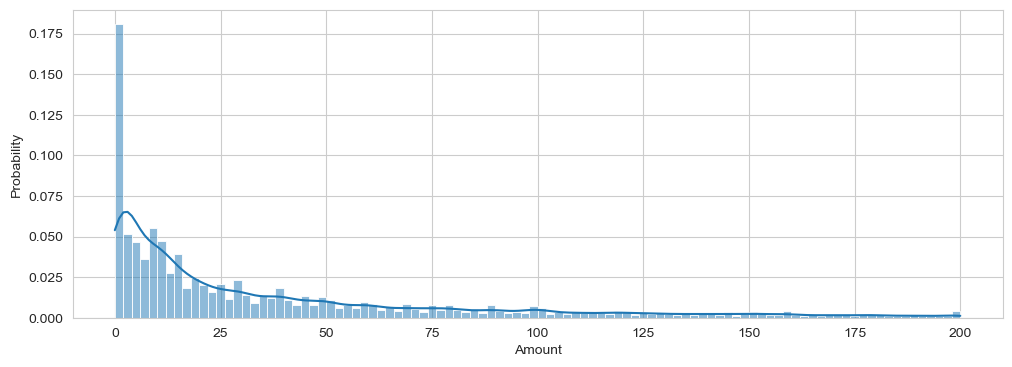

In [20]:
fig, ax = plt.subplots(figsize=(12,4))
sns.histplot(data=X_combined[X_combined['Amount'].between(0,200)], x='Amount', bins=100, stat='probability',kde=True);

The majority of Amount is distributed roughly exponentially, with a peak between $0-5



Transactions with a trivial amount i.e. $0.00-2.00 are far more likely to be fraudulent than safe. Little correlation for larger amounts.

Transactions in this range have a fraud rate that is 3x the overall rate. Perhaps this is because no money actually goes through as fraud is detected or because fraudsters try to spend as close to 0 as possible to test if a card will work. Either way, we can include it as a risk factor in our model.


In [21]:


print(X_combined.loc[X_combined['Amount'].between(0,2)]['Class'].value_counts())
print(X_combined['Class'].value_counts())
print(f"Percentage of transactions < $2.00 that are fradulent: {round((365/84670)*100, 4)}")
print(f"Percentage of all transactions that are fradulent: {round((942/501913)*100, 4)}")



0    84670
1      365
Name: Class, dtype: int64
0    501913
1       942
Name: Class, dtype: int64
Percentage of transactions < $2.00 that are fradulent: 0.4311
Percentage of all transactions that are fradulent: 0.1877


In [22]:
X_combined['Risk_factor'] = (X_combined['Amount'] <= 2)*1
X_test['Risk_factor'] = (X_test['Amount'] <= 2)*1

## Preprocessing



    Amount column is the only column to be scaled since the V columns are already scaled from PCA. StandardScaler might be too susceptible to outliers therefore opt for RobustScaler.

    Drop the Time column in favour of Time_bucket.


In [23]:
# separate out target and drop class and Time
y = X_combined['Class']
X_combined.drop(axis=1, columns=['Time', 'Class'], inplace=True)
X_test.drop(axis=1, columns=['Time'], inplace=True)

In [24]:
robust_scaler = RobustScaler()
robust_cols = ['Amount']

ord_enc = OrdinalEncoder()
ord_cols = ['Time_bucket']

preprocessor = ColumnTransformer(transformers=[('robust_scaler', robust_scaler, robust_cols),
                                                  ('ord_enc', ord_enc, ord_cols)],
                                    verbose_feature_names_out=True,
                                    remainder='passthrough')

In [25]:
X_scaled = pd.DataFrame()
X_test_scaled = pd.DataFrame()

In [26]:
X_scaled[X_combined.columns] = preprocessor.fit_transform(X_combined)
X_test_scaled[X_test.columns] = preprocessor.transform(X_test)

#### Correlation


    Very little correlation from the V features as expected from PCA.
    All the features seem to have low correlation with the class.
    No need to plot boxplots and remove outliers to improve the data quality.


In [27]:
full_df = X_scaled.copy()
full_df['Class'] = y

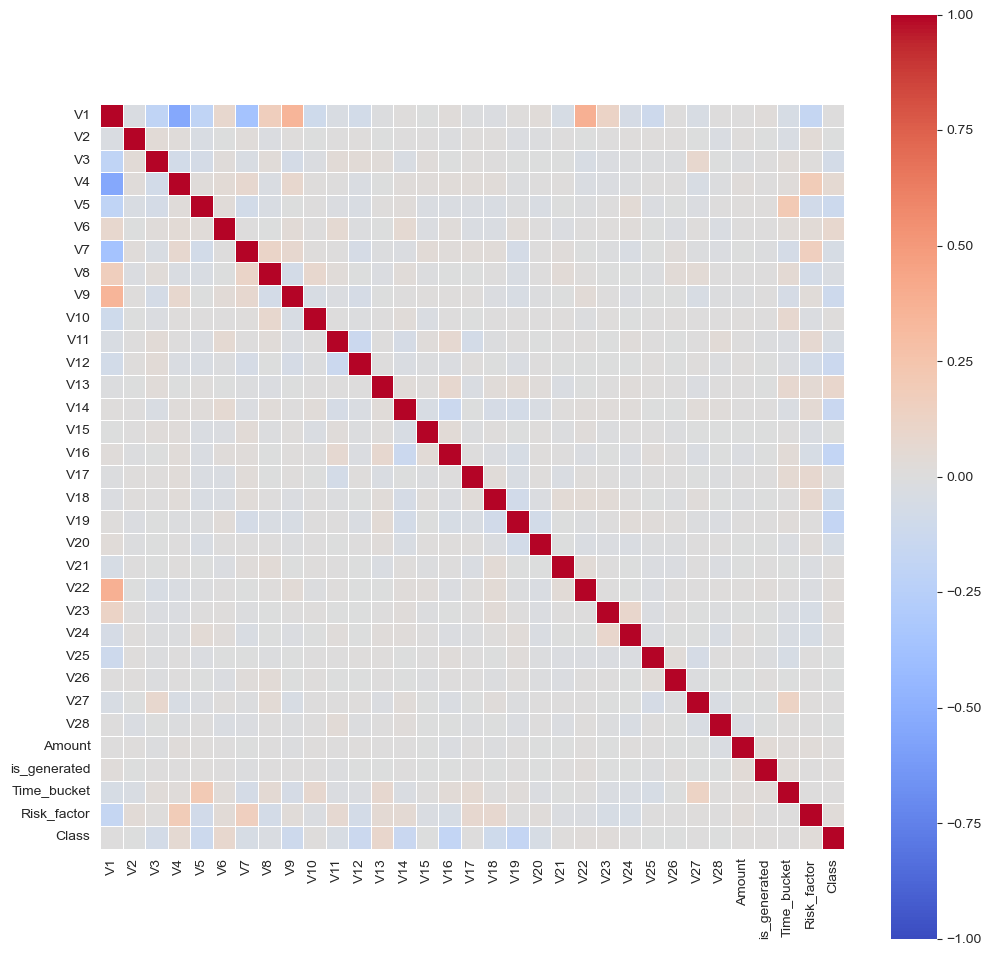

In [28]:
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(full_df.corr(), cmap='coolwarm', square=True, linewidths=0.5, vmin=-1, vmax=1);

In [29]:
# check correlation of each feature with the class
full_df.corr()['Class'].sort_values(ascending=False)

Class           1.000000
V13             0.088431
V6              0.084553
V4              0.055705
Risk_factor     0.025238
V22             0.019390
V23             0.018716
V21             0.014443
Amount          0.012893
is_generated    0.011892
V10             0.008502
V1              0.007589
Time_bucket     0.005426
V24             0.003252
V27             0.002298
V17             0.001087
V15            -0.000085
V2             -0.000135
V28            -0.004743
V26            -0.006339
V25            -0.007514
V8             -0.025911
V11            -0.044102
V7             -0.047615
V20            -0.048296
V3             -0.071256
V18            -0.106330
V9             -0.114304
V5             -0.124791
V12            -0.128322
V14            -0.142855
V19            -0.174624
V16            -0.182936
Name: Class, dtype: float64

## Modelling


- XGBClassifier, CatBoostClassifier and LGBMClassifier performed the best during initial testing so we will opt for an ensemble of these for our final predictions.

- Model parameters taken from this brilliant notebook.

- Use undersampling on the legitimate transactions to balance out the data the models are trained on.

- I used StratifiedKFold cross validation to train each model on different portions of the sampled data and combined each model's output later on

#### Sampling



We will use an undersampling method, where all of the fraudulent transactions are used in training a model but a subsample of varying size will be used for the legitimate transactions.


In [30]:
X_sample = X_scaled.copy()
X_sample['Class'] = y

fraud_df = X_sample[X_sample['Class'] == 1]
legit_df = X_sample[X_sample['Class'] == 0]

In [31]:
print(f"""fraud_df: {fraud_df.shape}
legit_df: {legit_df.shape}""")

fraud_df: (942, 33)
legit_df: (501913, 33)


In [32]:
clfs = []
n_folds = 5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=0)

### Model 1: XGBClassifier

In [35]:
xgb_params = {'n_estimators'     : 2000,
              'min_child_weight' : 96,
              'max_depth'        : 7,
              'learning_rate'    : 0.18,
              'subsample'        : 0.95,
              'colsample_bytree' : 0.95,
              'reg_lambda'       : 1.50,
              'reg_alpha'        : 1.50,
              'gamma'            : 1.50,
              'max_bin'          : 512,
              'random_state'     : 0,
              'objective'        : 'binary:logistic',
              'tree_method'      : 'hist',
              'eval_metric'      : 'auc'
             }

xgb_clf = XGBClassifier(**xgb_params)

In [36]:
# Try out multiple sample sizes, 50000 was optimal

scores = []
xgb_test_preds = []
# sample_sizes = [1000, 10000, 50000, 100000, 200000, 400000, 500000]
# sample_sizes = [942, 5000, 10000, 25000, 50000, 75000]
sample_sizes = [50000]

for sample_size in sample_sizes:
    sample = legit_df.sample(n=sample_size)
    merged = pd.concat([sample, fraud_df], ignore_index=True)
    X_sub = merged.drop(axis=1, columns='Class')
    y_sub = merged['Class']
    for train_index, valid_index in skf.split(X_sub, y_sub):
        X_train, X_valid = X_sub.loc[train_index], X_sub.loc[valid_index]
        y_train, y_valid = y_sub[train_index], y_sub[valid_index]

        clf = xgb_clf
        fit = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)
        preds = clf.predict_proba(X_valid.values)[:,1]
        scores.append(roc_auc_score(y_valid, preds))
        xgb_test_preds.append(clf.predict_proba(X_test_scaled)[:,1])
    
    print(f"Sample Size: {sample_size} - XGBClassifier Mean Score: {np.mean(scores[-5:])}")

Sample Size: 50000 - XGBClassifier Mean Score: 0.929650395699651


### Model 2: CatboostClassifier

In [37]:


catboost_params = {'n_estimators': 500,
                   'learning_rate': 0.03, 
                   'one_hot_max_size': 12,
                   'depth': 4,
                   'l2_leaf_reg': 0.014,
                   'colsample_bylevel': 0.06,
                   'min_data_in_leaf': 12,
                   'boosting_type': 'Plain',
                   'bootstrap_type': 'Bernoulli',
                   'verbose': False}

catboost_clf = CatBoostClassifier(**catboost_params)



In [38]:
scores = []
catboost_test_preds = []
sample_sizes = [50000]

for sample_size in sample_sizes:
    sample = legit_df.sample(n=sample_size)
    merged = pd.concat([sample, fraud_df], ignore_index=True)
    X_sub = merged.drop(axis=1, columns='Class')
    y_sub = merged['Class']
    for train_index, valid_index in skf.split(X_sub, y_sub):
        X_train, X_valid = X_sub.loc[train_index], X_sub.loc[valid_index]
        y_train, y_valid = y_sub[train_index], y_sub[valid_index]

        clf = catboost_clf
        fit = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)
        preds = clf.predict_proba(X_valid.values)[:,1]
        scores.append(roc_auc_score(y_valid, preds))
        catboost_test_preds.append(clf.predict_proba(X_test_scaled)[:,1])
    
    print(f"Sample Size: {sample_size} - Catboost Mean Score: {np.mean(scores[-5:])}")

Sample Size: 50000 - Catboost Mean Score: 0.926115587076438


### Model 3: LGBMClassifier

In [39]:
lgbm_params = {'n_estimators': 500,
                 'num_rounds': 274,
                 'learning_rate': 0.1,
                 'num_leaves': 195,
                 'max_depth': 9,
                 'min_data_in_leaf': 46,
                 'lambda_l1': 0.01,
                 'lambda_l2': 0.6,
                 'min_gain_to_split': 1.42,
                 'bagging_fraction': 0.45,
                 'feature_fraction': 0.3,
                 'verbose':-1}

lgbm_clf = LGBMClassifier(**lgbm_params)

In [40]:
scores = []
lgbm_test_preds = []
sample_sizes = [50000]

for sample_size in sample_sizes:
    sample = legit_df.sample(n=sample_size)
    merged = pd.concat([sample, fraud_df], ignore_index=True)
    X_sub = merged.drop(axis=1, columns='Class')
    y_sub = merged['Class']
    for train_index, valid_index in skf.split(X_sub, y_sub):
        X_train, X_valid = X_sub.loc[train_index], X_sub.loc[valid_index]
        y_train, y_valid = y_sub[train_index], y_sub[valid_index]

        clf = lgbm_clf
        fit = clf.fit(X_train, y_train, eval_set=[(X_valid, y_valid)],verbose=False)
        preds = clf.predict_proba(X_valid.values)[:,1]
        scores.append(roc_auc_score(y_valid, preds))
        lgbm_test_preds.append(clf.predict_proba(X_test_scaled)[:,1])
    
    print(f"Sample Size: {sample_size} - LGBM Mean Score: {np.mean(scores[-5:])}")

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=46
[LightGBM] [Warning] min_gain_to_split is set=1.42, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=1.42
[LightGBM] [Warning] lambda_l1 is set=0.01, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.01
[LightGBM] [Warning] bagging_fraction is set=0.45, subsample=1.0 will be ignored. Current value: bagging_fraction=0.45
[LightGBM] [Warning] lambda_l2 is set=0.6, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6
[LightGBM] [Warning] num_iterations is set=274, num_rounds=274 will be ignored. Current value: num_iterations=274
[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] min_data_in_leaf is set=46, min_child_sam

### Test Submission

In [41]:
xgb_preds = np.stack(xgb_test_preds).mean(0)
catboost_preds = np.stack(catboost_test_preds).mean(0)
lgbm_preds = np.stack(lgbm_test_preds).mean(0)

test_preds = np.stack((xgb_preds, catboost_preds, lgbm_preds)).mean(0)
test_preds

array([0.02494393, 0.0109968 , 0.00559017, ..., 0.01053691, 0.00572849,
       0.00673352])

xgb after kfold and gridsearch get the best result so i used that to predict

In [42]:
submission = pd.DataFrame({'id': test_ids,
                              'Class': test_preds})
submission.to_csv('Mysubmission.csv', index=False)